# EdgeSHAPer implementation

Explain the graph classification using Shapley values for edges.
Determine the contribution of each edge towards the output value (predicted problability).

In [1]:
import torch
from torchdrug import data
import pandas as pd
import numpy as np
import random

from rdkit import Chem
from rdkit.Chem import Draw
from pysmiles import read_smiles
import networkx as nx

from rdkit_heatmaps import mapvalues2mol
from rdkit_heatmaps.utils import transform2png

from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
# for debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Reproducibility Settings

In [3]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

## Data Loading

In [4]:
####do not modify those to reproduce paper experiments#####
DATASET_TYPE = "single" 
TARGET = 1
TRAINING_SET_SPLIT = "FULL" #FULL, 0, 1, 2
MODEL_NUM = 0 
SAVE = True
TARGET_CPDS = "P14416_P42336" 
DATASET_NAME = "chembl29_predicting_target_" + TARGET_CPDS + "_target_"+ str(TARGET) +"_vs_random_cpds"
CSV_DATA_PATH = "../data/"+ DATASET_NAME + ".csv"
##################################################

smiles_df = pd.read_csv(CSV_DATA_PATH, sep = ",")
display(smiles_df.head())
display(smiles_df.shape)

,nonstereo_aromatic_smiles,target_pair,label
0,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
1,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,P14416_P42336,0
2,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,P14416_P42336,0
3,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
4,Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1,P14416_P42336,0


(8348, 3)

## Define Custom Class
We need to define the ChEMBL datasets class in order to load the model

In [5]:
import os

from torchdrug.core import Registry as R
from torchdrug.utils import doc


@R.register("datasets.ChEMBL") #only first time you launch the class
#@doc.copy_args(data.MoleculeDataset.load_csv, ignore=("path", "smiles_field", "target_fields"))
class ChEMBL(data.MoleculeDataset):
    

    def __init__(self, path, smiles_field, target_fields, verbose=1, **kwargs):
        
        self.path = path
        self.smiles_field = smiles_field
        self.target_fields= target_fields
       

        self.load_csv(self.path, smiles_field=self.smiles_field, target_fields=self.target_fields,
                      verbose=verbose, **kwargs)

In [6]:

target_fields = ["label"]
chembl_dataset = ChEMBL(path = CSV_DATA_PATH, smiles_field = "nonstereo_aromatic_smiles", target_fields = target_fields)

Loading ../data/chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds.csv: 100%|██████████| 8349/8349 [00:00<00:00, 87248.09it/s]
Constructing molecules from SMILES:  54%|█████▍    | 4500/8348 [00:13<00:11, 348.66it/s]c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES: 100%|██████████| 8348/8348 [00:26<00:00, 319.94it/s]


## Obtain edge index to use with PyG

Visualize molecules using NetworkX

In [7]:
smiles = chembl_dataset.smiles_list
mols = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols.append(read_smiles(chembl_dataset.smiles_list[i]))


  0%|          | 0/8348 [00:00<?, ?it/s]

Define edge index 

In [8]:
edge_index_list = []

for mol in tqdm(mols):
    adj = nx.to_scipy_sparse_matrix(mol).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    edge_index_list.append(edge_index)

display(len(mols))

  0%|          | 0/8348 [00:00<?, ?it/s]

8348

Define torchdrug dataset in order to get node features

In [9]:
mols_torchdrug_format = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols_torchdrug_format.append(data.Molecule.from_smiles(chembl_dataset.smiles_list[i], with_hydrogen = False))


  0%|          | 0/8348 [00:00<?, ?it/s]

c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)


## Create Custom Dataset

In [10]:
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_list = []
y = torch.LongTensor(chembl_dataset.targets["label"]).to(device)

for i in tqdm(range(len(mols))):
    data_list.append(Data(x = mols_torchdrug_format[i].node_feature, edge_index = edge_index_list[i], y = y[i], smiles = chembl_dataset.smiles_list[i]))


  0%|          | 0/8348 [00:00<?, ?it/s]

In [11]:
class ChEMBLDatasetPyG(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_list = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        
        self.data_list = data_list

        
        data_list = self.data_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.data, self.slices = self.collate(data_list)
        

In [12]:
dataset = ChEMBLDatasetPyG(".", data_list = data_list)

Split data in train/val/test (0.8/0.1/0.1)

In [13]:
lengths = [int(0.8 * len(chembl_dataset)), int(0.1 * len(chembl_dataset))]
lengths += [len(chembl_dataset) - sum(lengths)]

print(lengths)
dataset = dataset.shuffle()
train_data = dataset[:lengths[0]]
val_data = dataset[lengths[0]+1:lengths[0] + lengths[1]+1]
test_data = dataset[lengths[0] + lengths[1] + 1: ]  
len(train_data), len(val_data), len(test_data)

[6678, 834, 836]


(6678, 834, 835)

In [14]:
batch_size= 32
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## GCN Definition

In [15]:
from torch_geometric.nn import GCNConv, Linear
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(chembl_dataset.node_feature_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=256).to(device)
print(model)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


## Load the Model

In [16]:
import os.path as osp

if TRAINING_SET_SPLIT == None:
    MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_model_" + str(MODEL_NUM) + ".ckpt"
else:
    MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_training_set_" + str(TRAINING_SET_SPLIT) + "_model_" + str(MODEL_NUM) + ".ckpt"
ckpt_path = osp.join(MODEL_PATH)
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)

## Test the Model

In [17]:
def test(loader):
     model.eval()

     correct = 0
     for data in loader:  
         data = data.to(device)
         
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  
         correct += int((pred == data.y).sum()) 
     return correct / len(loader.dataset)

test_acc = test(test_loader)    
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.9749


## EdgeSHAPer

* Players = edges
* Value = predicted probability $v$
* $E$ = set of all edges
* $v(E)$ = value of all the edges == original predicted prob
* $\phi_j(v)$ = payout for the contribution of edge j
* $S$ = all the possible subsets of edges excluding j
* |S| = size of S
* $v(S)$ is the value achieved by subset S
* $v(S∪{j})$ is the realized value after j joins S

Shapley values compouted as:

$\phi_j(v) = \frac{1}{|E|} \sum_S \frac{v(S \cup {j}) - v(S)}{\binom{|E|-1}{|S|}}$

Cc1ncsc1-c1nnc(SCCCN2CCC3(CC3c3ccc(C(F)(F)F)cc3)C2)n1C
tensor([[ 11.9760, -11.6393]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[1.0000e+00, 5.5466e-11]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:468: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0

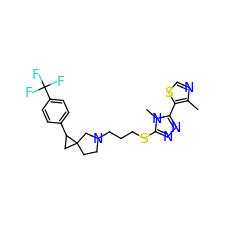

In [18]:
test_set_index = 112 
test_cpd = test_data[test_set_index].to(device)
print(test_cpd.smiles)
mol_test = data.Molecule.from_smiles(test_cpd.smiles, with_hydrogen=False)
mol_test.visualize()

model.eval()
# all nodes belong to same graph
batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
out_prob = F.softmax(out, dim = 1)
target_class = torch.argmax(out_prob[0]).item()
print(out)
print(out_prob)
target_class

Creating folder and saving smiles

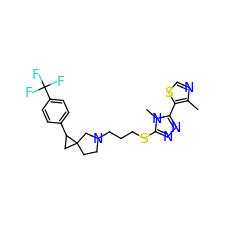

In [19]:
if SAVE:
    
    if DATASET_TYPE == "dual":
        FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS
    else:
        FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS +"/Target " + str(TARGET) + " vs Random"

    CPD_FOLDER_NAME = FOLDER_NAME + "/" + test_cpd.smiles

    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)

    if not os.path.exists(CPD_FOLDER_NAME):
        os.makedirs(CPD_FOLDER_NAME)


    mol_test.visualize(save_file = CPD_FOLDER_NAME + "/" + test_cpd.smiles + ".png")


In [20]:
E = test_cpd.edge_index
num_nodes = test_cpd.x.shape[0]
max_num_edges = num_nodes*(num_nodes-1)
num_edges = E.shape[1]
graph_density = num_edges/max_num_edges
P = graph_density 

In [21]:
M = 100 #200
phi_edges = []

from numpy.random import default_rng
rng = default_rng(seed = 42) 
model.eval()

log_odds = False
for j in tqdm(range(num_edges)):
    marginal_contrib = 0
    for i in range(M):
        E_z_mask = rng.binomial(1, P, num_edges)
        
        E_mask = torch.ones(num_edges)
        pi = torch.randperm(num_edges)

        E_j_plus_index = torch.ones(num_edges, dtype=torch.int)
        E_j_minus_index = torch.ones(num_edges, dtype=torch.int)
        selected_edge_index = np.where(pi == j)[0].item()
        for k in range(num_edges):
            if k <= selected_edge_index:
                E_j_plus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_plus_index[pi[k]] = E_z_mask[pi[k]]

        for k in range(num_edges):
            if k < selected_edge_index:
                E_j_minus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_minus_index[pi[k]] = E_z_mask[pi[k]]


        #we compute marginal contribs
        
        # with edge j
        retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
        E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        
        out = model(test_cpd.x, E_j_plus, batch=batch)
        out_prob = None

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out #out prob variable now containts log_odds
        
        V_j_plus = out_prob[0][target_class].item() 

        # without edge j
        retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
        E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        out = model(test_cpd.x, E_j_minus, batch=batch)

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out
        
        V_j_minus = out_prob[0][target_class].item()

        marginal_contrib += (V_j_plus - V_j_minus)

    phi_edges.append(marginal_contrib/M)     
         
sum(phi_edges)

  0%|          | 0/74 [00:00<?, ?it/s]

0.9615019685999536

In [22]:
print(out_prob)
print(phi_edges)

tensor([[1.0000e+00, 1.9552e-09]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[-0.007540009424477076, -0.0017900086534671758, 0.006461026081251717, -0.007153487888618303, -0.013087018211198518, -0.01285442332195166, -0.0014355085448260673, 0.004954869422845855, -0.006814157182230365, -0.004757985650856113, 0.005263711197665753, 0.02244052956233046, -0.0012870132254563067, 0.002902872151790022, -0.014176112155091231, 0.0011518959596573727, 0.014691409844003517, -0.007589337931992918, 0.009377436690708462, 0.04447151922310127, -0.014085741899568238, 0.07763169019613649, 0.0037726177135813405, -0.0022155376010182274, -0.09915575006027462, 0.04496525287856036, -0.02926422327150557, 0.04773006953074611, 0.02275690484024643, 0.0430305139219688, 0.0677334605504812, 0.04341999073654762, 0.14325948127143007, 0.05910764800874416, 0.06146347432464844, 0.004484607694918189, 0.03301021008573448, -0.007885202913426665, 0.05901925819305612, 0.00953319984513366, -0.003495249961595197, 0.010162139337

In [23]:
if SAVE:
    INFO_EXPLANATIONS = "info_explanations"
    if TRAINING_SET_SPLIT != None:
        INFO_EXPLANATIONS += "_training_split_" + str(TRAINING_SET_SPLIT)
        
    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "w+") as saveFile:
        saveFile.write("Test set index: " + str(test_set_index) + "\n\n")

    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("Target Class: " + str(target_class) + "\n\n")

    tagert_compound_sample = "TARGET" if target_class == 0 else "RANDOM"

    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("Target compound: " + str(tagert_compound_sample) + "\n\n")

    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("Sum of Shapley Values: " + str(sum(phi_edges)) + "\n\n")

    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("Shapley values:\n")
        for phi_val in phi_edges:
            saveFile.write(str(phi_val) + "\n")
    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("\nEdge Index:\n")
        saveFile.write(str(test_cpd.edge_index) + "\n\n")
        saveFile.write("Edge index shape: " + str(test_cpd.edge_index.shape) +"\n")

## Visualize Explanation

In [24]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

important_edges_ranking = np.argsort(-np.array(phi_edges))
print(important_edges_ranking)
sorted_phi_edges = sorted(phi_edges, reverse = True)

[32 68 21 30 34 33 38 69 45 27 25 19 31 29 57 36 72 63 61 28 11 42 73 16
 62 43 47 44 49 41 39 18  2 64 10  7 67 35 59 22 53 13 65 52 15 46 71 12
  6 51  1 56 23 40 70 54  9 50  8  3  0 17 37 48 66 55  5  4 60 20 14 58
 26 24]


## Visualize Explanation - Moleculized

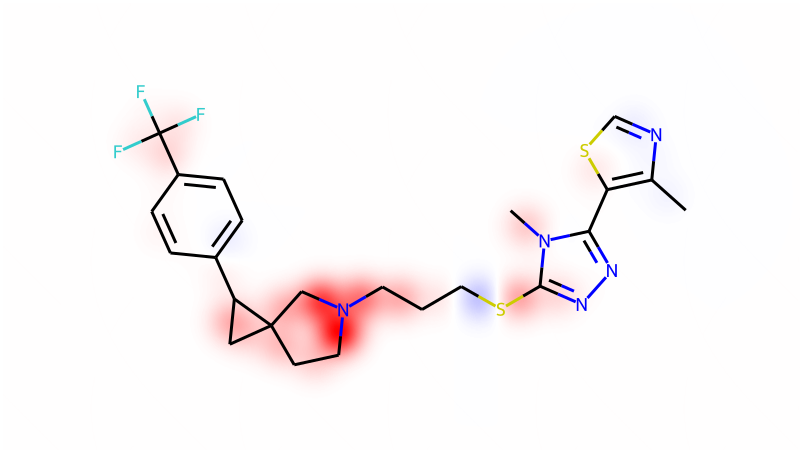

<Figure size 432x288 with 0 Axes>

In [25]:
edge_index = test_cpd.edge_index
test_mol = Chem.MolFromSmiles(test_cpd.smiles)
test_mol = Draw.PrepareMolForDrawing(test_mol)

num_bonds = len(test_mol.GetBonds())
num_atoms = len(test_mol.GetAtoms())

rdkit_bonds = {}

for i in range(num_bonds):
    init_atom = test_mol.GetBondWithIdx(i).GetBeginAtomIdx()
    end_atom = test_mol.GetBondWithIdx(i).GetEndAtomIdx()
    bond_type = test_mol.GetBondWithIdx(i).GetBondType()
    
    rdkit_bonds[(init_atom, end_atom)] = i

rdkit_bonds_phi = [0]*num_bonds
for i in range(len(phi_edges)):
    phi_value = phi_edges[i]
    init_atom = edge_index[0][i].item()
    end_atom = edge_index[1][i].item()
    
    if (init_atom, end_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(init_atom, end_atom)]
        rdkit_bonds_phi[bond_index] += phi_value
    if (end_atom, init_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(end_atom, init_atom)]
        rdkit_bonds_phi[bond_index] += phi_value

plt.clf()
canvas = mapvalues2mol(test_mol, None, rdkit_bonds_phi, atom_width=0.2, bond_length=0.5, bond_width=0.5)
img = transform2png(canvas.GetDrawingText())

if SAVE:
    if TRAINING_SET_SPLIT == None:
        img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_EdgeSHAPer_MC_" + str(M) + "_heatmap.png")
    else:
        img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_EdgeSHAPer_MC_" + str(M) + "training_split_" + str(TRAINING_SET_SPLIT) + "_heatmap.png") 
img

## GNNExplainer
Explain the classification of a test cpd using GNNExplainer

In [26]:
import os.path as osp

import torch
import torch.nn.functional as F


from torch_geometric.nn import GNNExplainer

epochs = 100

x, edge_index, edge_weight = test_cpd.x, test_cpd.edge_index, None

explainer = GNNExplainer(model, epochs=epochs, return_type='log_prob')

node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

Explain graph: 100%|██████████| 100/100 [00:02<00:00, 40.58it/s]


GNNExplainer Visualization - Moleculized

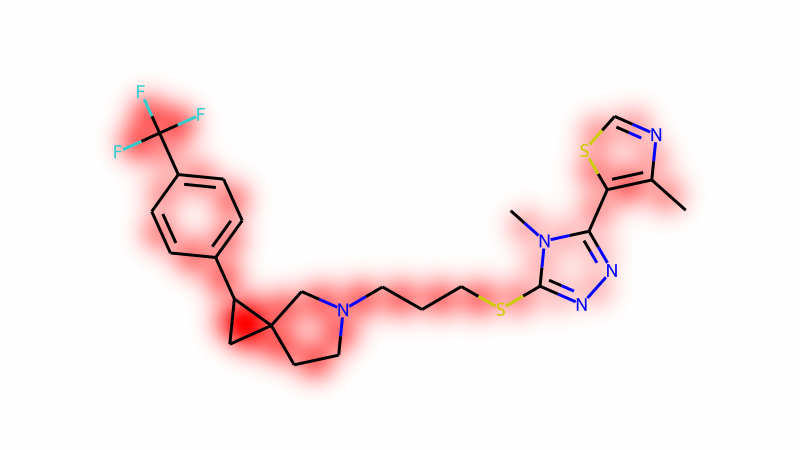

<Figure size 432x288 with 0 Axes>

In [27]:
rdkit_bonds_GNNExpl_importance = [0]*num_bonds
for i in range(len(edge_mask)):
    GNNExpl_importance_value = edge_mask[i]
    init_atom = edge_index[0][i].item()
    end_atom = edge_index[1][i].item()
    
    if (init_atom, end_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(init_atom, end_atom)]
        rdkit_bonds_GNNExpl_importance[bond_index] += GNNExpl_importance_value.item()
    if (end_atom, init_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(end_atom, init_atom)]
        rdkit_bonds_GNNExpl_importance[bond_index] += GNNExpl_importance_value.item()

plt.clf()
canvas = mapvalues2mol(test_mol, None, rdkit_bonds_GNNExpl_importance, atom_width=0.2, bond_length=0.5, bond_width=0.5) 
img = transform2png(canvas.GetDrawingText())

if SAVE:
    if TRAINING_SET_SPLIT == None:
        img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_" + "heatmap.png")
    else:
        img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_" + "training_split_" + str(TRAINING_SET_SPLIT) + "_heatmap.png") 
img